In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-black-money-transactions-dataset/Big_Black_Money_Dataset.csv


## Background of This Project
The dataset is designed to offer insights into various aspects of financial movements often associated with illicit activities. Often with financial instuitions are ethically obliged to identify certain black money laundering activities due to inflow of black money into economy leads to corruption of the society.

This is because every black money is collected from either illegal activities or legal income that is not taxed publically which serves some negative purpose of tax saving. Especially when such black money goes through money laundering and is publicly used, societal structure is destroyed, bringing the main cause of rise in criminal rate. Moreover, these black money cannot be included in the gross national product (GNP) of a country, exceptionally underestimating country's economic situation. These inaccuracies affect in country's policy making and eventual welfare of the population. 

Considering such background knowledge along with comprehensive attributes ranging from transaction amounts to risk scores, I will be attempting to:

* draw some patterns on financial crime patterns in order to successfully classify whether the new transaction activity is either legal or illegal to ease the problems arose from such financial background of black money -> **Source of Money Classification**  

**Columns:**

* Transaction ID: Unique identifier for each transaction. (e.g., TX0000001)
* Country: Country where the transaction occurred. (e.g., USA, China)
* Amount (USD): Transaction amount in US Dollars. (e.g., 150000.00)
* Transaction Type: Type of transaction. (e.g., Offshore Transfer, Property Purchase)
* Date of Transaction: The date and time of the transaction. (e.g., 2022-03-15 14:32:00)
* Person Involved: Name or identifier of the person/entity involved. (e.g., Person_1234)
* Industry: Industry associated with the transaction. (e.g., Real Estate, Finance)
* Destination Country: Country where the money was sent. (e.g., Switzerland)
* Reported by Authority: Whether the transaction was reported to authorities. (e.g., True/False)
* **Source of Money**: Origin of the money. (e.g., Legal, Illegal) **This will be our target label.**
* Money Laundering Risk Score: Risk score indicating the likelihood of money laundering (1-10). (e.g., 8)
* Shell Companies Involved: Number of shell companies used in the transaction. (e.g., 3)
* Financial Institution: Bank or financial institution involved in the transaction. (e.g., Bank_567)
* Tax Haven Country: Country where the money was transferred to a tax haven. (e.g., Cayman Islands)

**Key Business Goals**
* Minimize risk of money laundering through identifying source of money from the dataset and eventually minimize risk of societal corruption

## Import Relevant Packages

In [2]:
pd.set_option('display.max_columns', None)
# General Modules
import datetime

# Model Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Model Construction
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report

In [3]:
## Read in CSV file
black_money = pd.read_csv('/kaggle/input/global-black-money-transactions-dataset/Big_Black_Money_Dataset.csv')
black_money.head()

,Transaction ID,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
0,TX0000000001,Brazil,3.267530e+06,Offshore Transfer,2013-01-01 00:00:00,Person_1101,Construction,USA,True,Illegal,6,1,Bank_40,Singapore
1,TX0000000002,China,4.965767e+06,Stocks Transfer,2013-01-01 01:00:00,Person_7484,Luxury Goods,South Africa,False,Illegal,9,0,Bank_461,Bahamas
2,TX0000000003,UK,9.416750e+04,Stocks Transfer,2013-01-01 02:00:00,Person_3655,Construction,Switzerland,True,Illegal,1,3,Bank_387,Switzerland
3,TX0000000004,UAE,3.864201e+05,Cash Withdrawal,2013-01-01 03:00:00,Person_3226,Oil & Gas,Russia,False,Illegal,7,2,Bank_353,Panama
4,TX0000000005,South Africa,6.433784e+05,Cryptocurrency,2013-01-01 04:00:00,Person_7975,Real Estate,USA,True,Illegal,1,9,Bank_57,Luxembourg


## EDA

In [4]:
## Access general information about the dataset
black_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  object 
 1   Country                      10000 non-null  object 
 2   Amount (USD)                 10000 non-null  float64
 3   Transaction Type             10000 non-null  object 
 4   Date of Transaction          10000 non-null  object 
 5   Person Involved              10000 non-null  object 
 6   Industry                     10000 non-null  object 
 7   Destination Country          10000 non-null  object 
 8   Reported by Authority        10000 non-null  bool   
 9   Source of Money              10000 non-null  object 
 10  Money Laundering Risk Score  10000 non-null  int64  
 11  Shell Companies Involved     10000 non-null  int64  
 12  Financial Institution        10000 non-null  object 
 13  Tax Haven Country

**It seems that we have 14 columns including the target label and 10K entries**
* There are some columns with float or int like **transaction amount**, **money laundering risk score**, and **shell companies invovled**

* Some variables need to be modified into datetime like **Date of Transaction** and some variables like **Shell Companies Involved** need to be converted into categorical variables

* There exists categorical variables like **Transaction Type**, **Tax Haven Country**, etc

In [5]:
## Convert necessary variables into optimum data types
black_money['Shell Companies Involved'] = black_money['Shell Companies Involved'].astype('str')

In [6]:
black_money['Date of Transaction'] = black_money['Date of Transaction'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [7]:
## Access statistical information about the dataset
black_money.describe(include = 'all')

,Transaction ID,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
count,10000,10000,1.000000e+04,10000,10000,10000,10000,10000,10000,10000,10000.000000,10000,10000,10000
unique,10000,10,NaN,5,NaN,6320,7,10,2,2,NaN,10,499,6
top,TX0000000001,China,NaN,Property Purchase,NaN,Person_7230,Finance,USA,False,Illegal,NaN,0,Bank_81,Panama
freq,1,1038,NaN,2086,NaN,7,1475,1061,7995,7017,NaN,1054,36,1743
mean,NaN,NaN,2.501818e+06,NaN,2013-07-28 07:30:00,NaN,NaN,NaN,NaN,NaN,5.526400,NaN,NaN,NaN
min,NaN,NaN,1.003180e+04,NaN,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,NaN,1.279005e+06,NaN,2013-04-15 03:45:00,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN
50%,NaN,NaN,2.501310e+06,NaN,2013-07-28 07:30:00,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN
75%,NaN,NaN,3.722416e+06,NaN,2013-11-09 11:15:00,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN
max,NaN,NaN,4.999812e+06,NaN,2014-02-21 15:00:00,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN


There seems to be no evidences of abnormal behaviour among the variables

In [8]:
## Check for null values 
black_money.isna().sum()

Transaction ID                 0
Country                        0
Amount (USD)                   0
Transaction Type               0
Date of Transaction            0
Person Involved                0
Industry                       0
Destination Country            0
Reported by Authority          0
Source of Money                0
Money Laundering Risk Score    0
Shell Companies Involved       0
Financial Institution          0
Tax Haven Country              0
dtype: int64

Luckily there are no null values!

In [9]:
## Check for duplicated values
black_money.duplicated().sum()

0

Even for the duplicating values, we cannot find any of them!

In [10]:
black_money.head()

,Transaction ID,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
0,TX0000000001,Brazil,3.267530e+06,Offshore Transfer,2013-01-01 00:00:00,Person_1101,Construction,USA,True,Illegal,6,1,Bank_40,Singapore
1,TX0000000002,China,4.965767e+06,Stocks Transfer,2013-01-01 01:00:00,Person_7484,Luxury Goods,South Africa,False,Illegal,9,0,Bank_461,Bahamas
2,TX0000000003,UK,9.416750e+04,Stocks Transfer,2013-01-01 02:00:00,Person_3655,Construction,Switzerland,True,Illegal,1,3,Bank_387,Switzerland
3,TX0000000004,UAE,3.864201e+05,Cash Withdrawal,2013-01-01 03:00:00,Person_3226,Oil & Gas,Russia,False,Illegal,7,2,Bank_353,Panama
4,TX0000000005,South Africa,6.433784e+05,Cryptocurrency,2013-01-01 04:00:00,Person_7975,Real Estate,USA,True,Illegal,1,9,Bank_57,Luxembourg


In [11]:
## Check for proportion of the target label
black_money['Source of Money'].value_counts(normalize = True)

Source of Money
Illegal    0.7017
Legal      0.2983
Name: proportion, dtype: float64

Although the target label is imbalanced, the extent at which it is imbalanced is not too extreme.

In [12]:
black_money.drop(columns = ['Transaction ID', 'Person Involved'], axis = 1, inplace = True)

Considering data from two variables possibly include unnecessary personal information, I decided to drop the two of them

In [13]:
## Arrange all numerical features to a single series
numerical_features = black_money.columns[(black_money.dtypes == int).values | (black_money.dtypes == float)]
numerical_features

Index(['Amount (USD)', 'Money Laundering Risk Score'], dtype='object')

In [14]:
## Arrange all categorical features to a single series
categorical_features = black_money.columns[black_money.dtypes == object].drop(['Financial Institution', 'Source of Money'])
categorical_features

Index(['Country', 'Transaction Type', 'Industry', 'Destination Country',
       'Shell Companies Involved', 'Tax Haven Country'],
      dtype='object')

Here I dropped Transaction ID as it

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


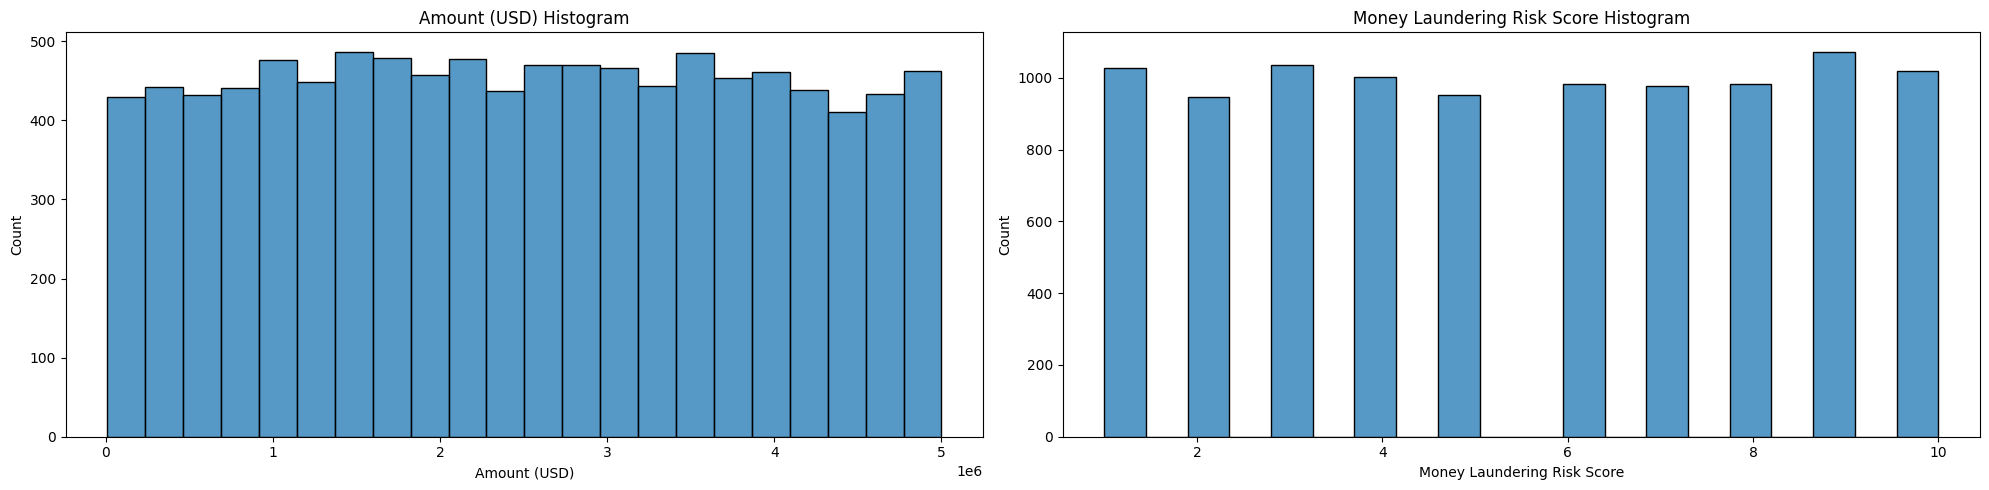

In [15]:
## Plot Histograms of numerical features
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

for i, feature in enumerate(numerical_features):
    sns.histplot(data = black_money, x = feature, ax = ax[i])
    ax[i].set_title(f'{feature} Histogram')
    
plt.tight_layout()
plt.show()

Both numerical features need to go through normalisation through MinMaxScaler considering their evenly distributed histogram 

**How can Normalizing help in this scenario?**
* Improve Convergence : Some algorithms based on gradient boosting converge faster when features are at similar scale

* Reduce the Noisiness coming from Bias : Especially for algorithms that rely on distance metrics

* Better Interpretation of Feature Importance : Normalising help in interperting feature importances

Now let's check presence of outliers in the datset.

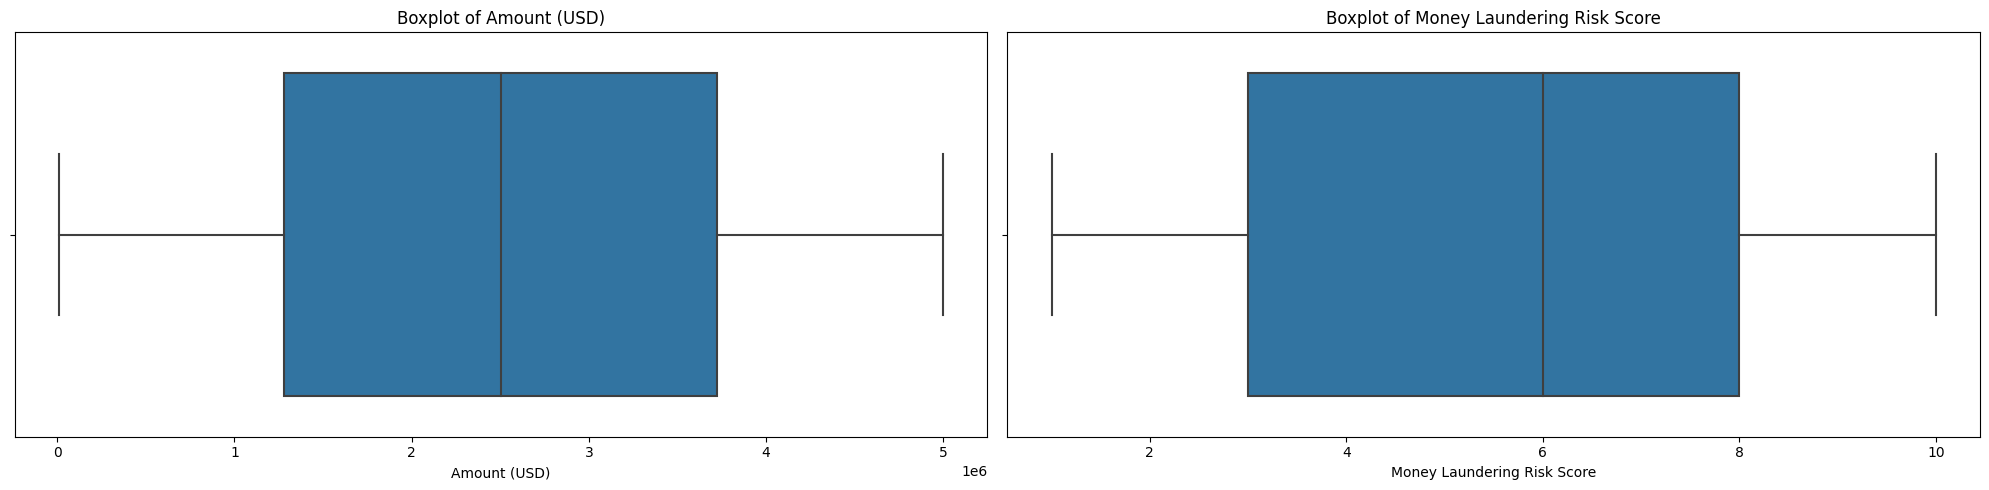

In [16]:
## Check if outliers are present in the variables
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

for i, feature in enumerate(numerical_features):
    sns.boxplot(data = black_money, x = feature, ax = ax[i])
    ax[i].set_title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()

Luckily there seems to be no outliers present in the numerical features but definitely we gotta check again.

In [17]:
## Check for outliers
def check_outliers(data, features):
    for feature in features:
        q1 = data[feature].quantile(0.25)
        q3 = data[feature].quantile(0.75)
        iqr = q3 - q1
        
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        
        num_of_outliers = len(data[(data[feature] < lower) | (data[feature] > upper)])
        print(f'Number of Outliers for {feature} : {num_of_outliers}')

check_outliers(black_money, numerical_features)

Number of Outliers for Amount (USD) : 0
Number of Outliers for Money Laundering Risk Score : 0


We have finally proved both visually and mathematically that there are no outliers among the numerical features!

It's now time to check for value counts of categorical features.

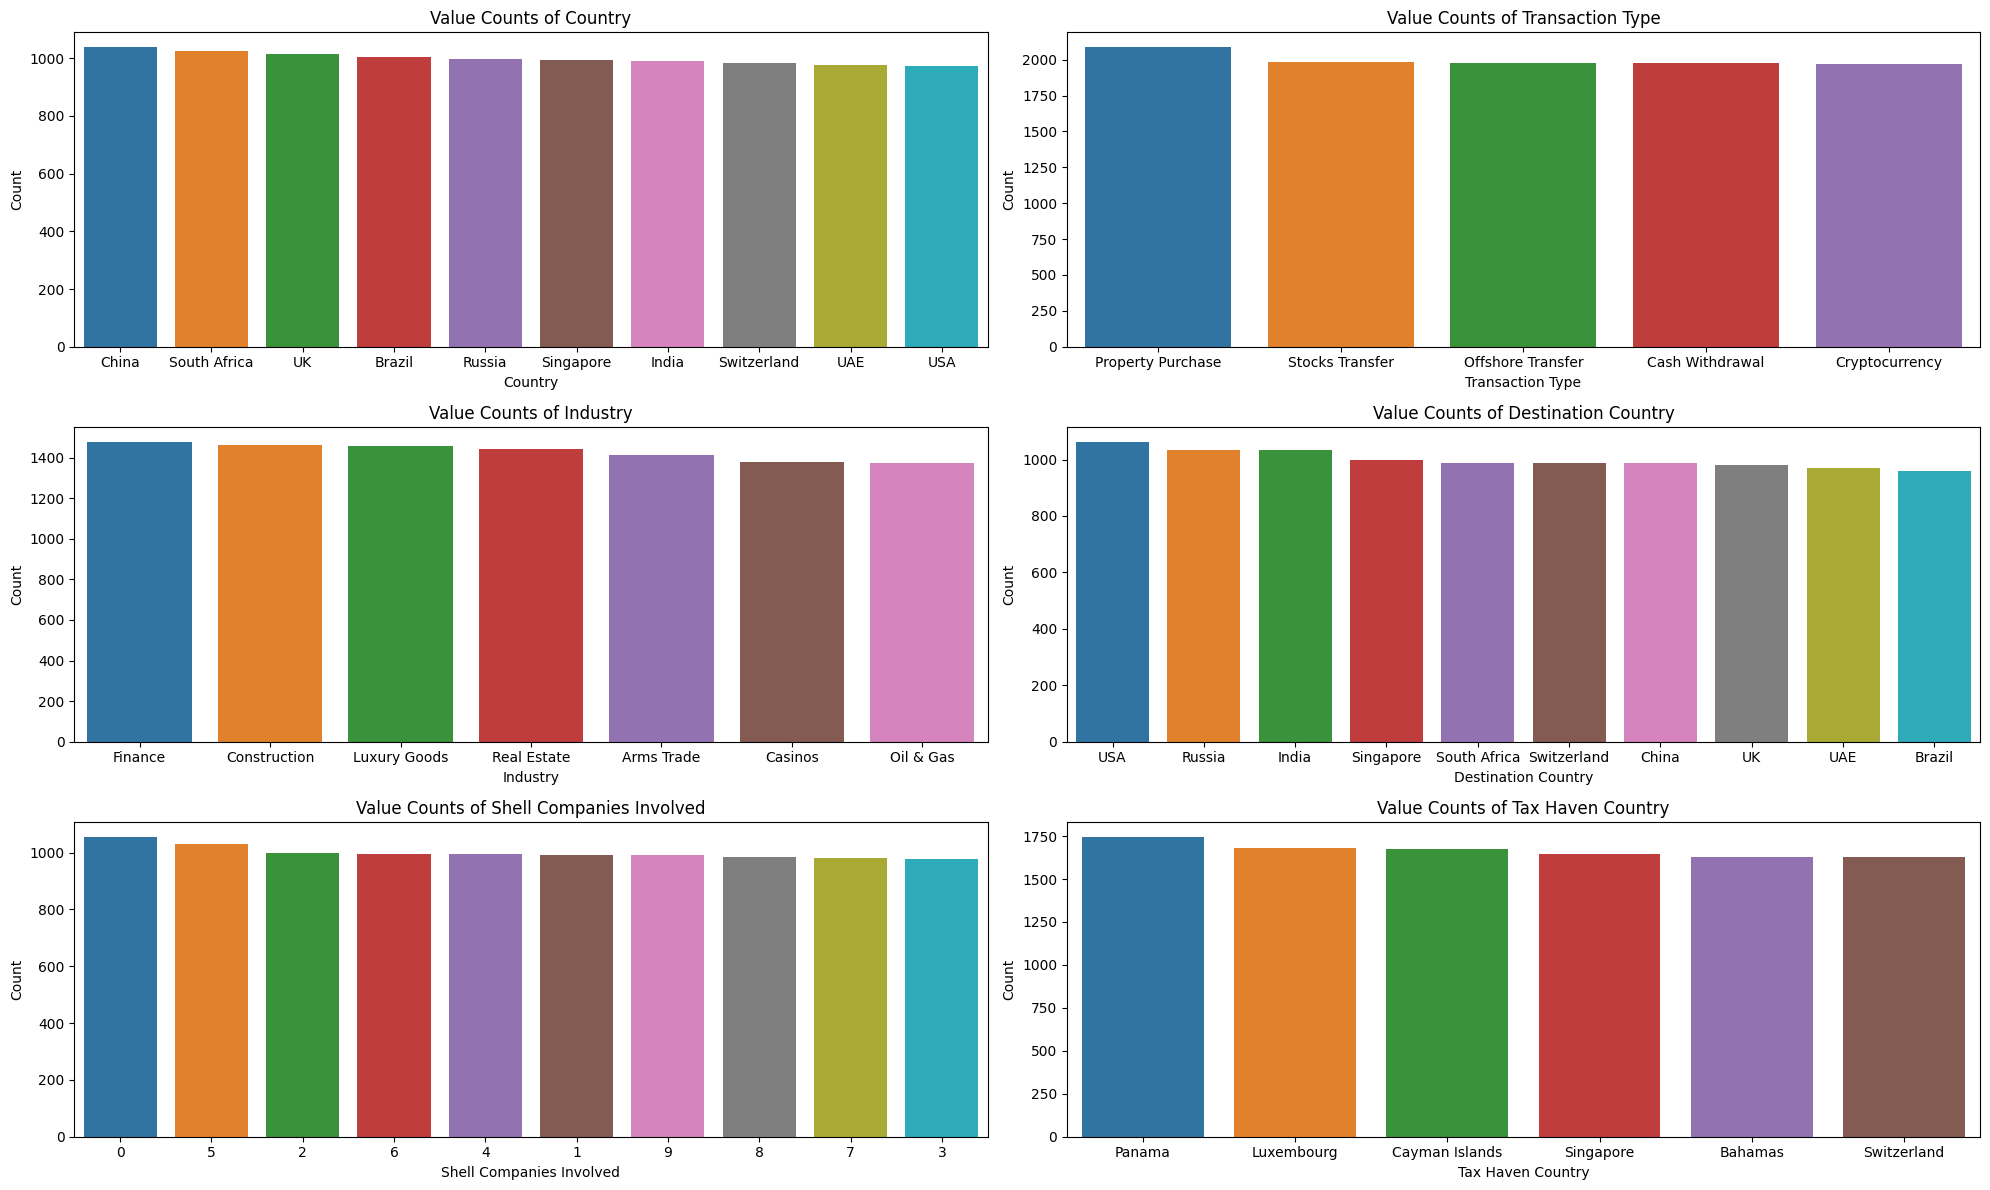

In [18]:
# Assuming categorical_features is a list of your categorical columns
plots_per_row = 2

# Calculate number of rows needed
num_of_rows = (len(categorical_features) + plots_per_row - 1) // plots_per_row

# Establish subplot template
fig, axes = plt.subplots(num_of_rows, plots_per_row, figsize=(20, 4 * num_of_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through the categorical features and show their distribution plots
for i, feature in enumerate(categorical_features):
    value_counts = black_money[feature].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
    axes[i].set_title(f'Value Counts of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# For better visualization
plt.tight_layout()
plt.show()

There are no need to deal with imbalanced categorical features like upsampling or downsampling so we are just going to deal with the data.

In [19]:
numerical_features

Index(['Amount (USD)', 'Money Laundering Risk Score'], dtype='object')

In [20]:
## Compute median amount of transaction for each risk score where source of money is illegal 
illegal = black_money[black_money['Source of Money'] == 'Illegal'].groupby('Money Laundering Risk Score')['Amount (USD)'].agg('median').reset_index()

## Compute median amount of transaction for each risk score where source of money is legal 
legal = black_money[black_money['Source of Money'] == 'Legal'].groupby('Money Laundering Risk Score')['Amount (USD)'].agg('median').reset_index()

## Then we merge the two dataframes
merged = illegal.join(legal, how = 'inner', on = 'Money Laundering Risk Score', lsuffix = '_illegal', rsuffix = '_legal')

## Pivot the table for beter analysis 
melted = merged.melt(id_vars='Money Laundering Risk Score', 
                     value_vars=['Amount (USD)_illegal', 'Amount (USD)_legal'],
                     var_name='Source', 
                     value_name='Median Amount (USD)')

## Show the table
melted

,Money Laundering Risk Score,Source,Median Amount (USD)
0,1,Amount (USD)_illegal,2.333666e+06
1,2,Amount (USD)_illegal,2.440039e+06
2,3,Amount (USD)_illegal,2.505242e+06
3,4,Amount (USD)_illegal,2.542990e+06
4,5,Amount (USD)_illegal,2.346925e+06
5,6,Amount (USD)_illegal,2.320006e+06
6,7,Amount (USD)_illegal,2.564091e+06
7,8,Amount (USD)_illegal,2.469210e+06
8,9,Amount (USD)_illegal,2.556774e+06
9,1,Amount (USD)_legal,2.460011e+06


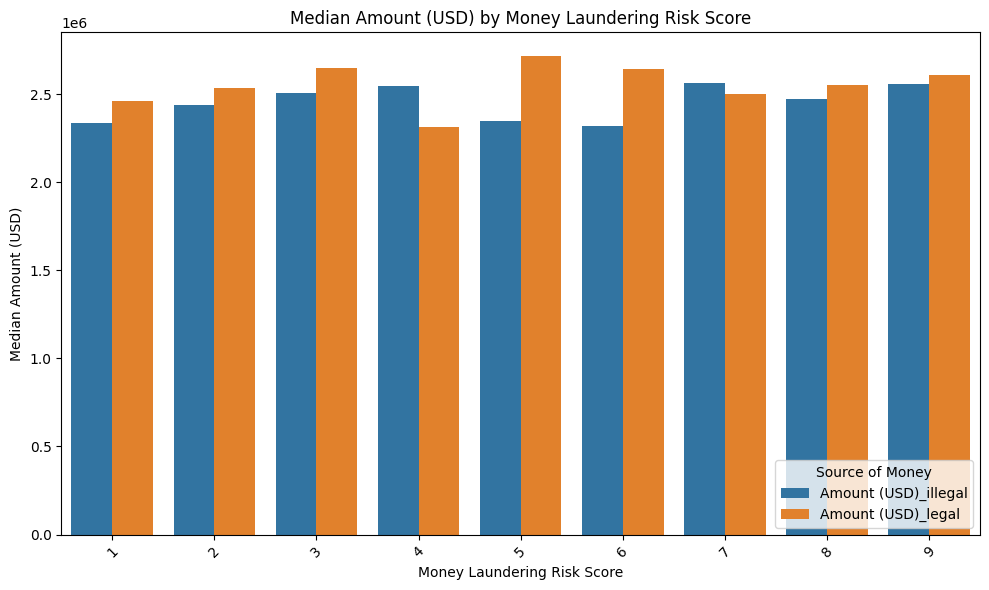

In [21]:
# Create the bar plot using the melted table
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Money Laundering Risk Score', y='Median Amount (USD)', hue='Source')
plt.title('Median Amount (USD) by Money Laundering Risk Score')
plt.xlabel('Money Laundering Risk Score')
plt.ylabel('Median Amount (USD)')
plt.legend(title='Source of Money', loc = 'lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* The trend shows that majority of transaction amount is lower in the legal money transaction than that of illegal money transaction

* There exists no particular trend in the case of money laundering risk score

Let's explore more about the categorical features and source of money

In [22]:
categorical_features

Index(['Country', 'Transaction Type', 'Industry', 'Destination Country',
       'Shell Companies Involved', 'Tax Haven Country'],
      dtype='object')

Let's start with Country variable

In [23]:
## Explore the grouped table using country variable
grped = black_money.groupby('Source of Money')['Country'].value_counts().unstack()
grped

Country,Brazil,China,India,Russia,Singapore,South Africa,Switzerland,UAE,UK,USA
Source of Money,,,,,,,,,,
Illegal,748,711,695,701,685,728,687,685,708,669
Legal,258,327,295,296,310,298,298,291,306,304


In [24]:
## Create a grouped table for visualisation
country_grouped = black_money.groupby('Country')['Source of Money'].value_counts().unstack()

## Create a new ratio column for each label in terms of better visualisation
country_grouped['Illegal_ratio'] = country_grouped['Illegal'] / (country_grouped['Illegal'] + country_grouped['Legal'])
country_grouped['Legal_ratio'] = country_grouped['Legal'] / (country_grouped['Illegal'] + country_grouped['Legal'])
country_grouped.sort_values(by = 'Illegal_ratio', inplace = True)
country_grouped

Source of Money,Illegal,Legal,Illegal_ratio,Legal_ratio
Country,,,,
China,711,327,0.684971,0.315029
USA,669,304,0.687564,0.312436
Singapore,685,310,0.688442,0.311558
Switzerland,687,298,0.697462,0.302538
UK,708,306,0.698225,0.301775
UAE,685,291,0.701844,0.298156
India,695,295,0.702020,0.297980
Russia,701,296,0.703109,0.296891
South Africa,728,298,0.709552,0.290448


In [25]:
## Barplot using counts of Source of Money 
fig = px.bar(country_grouped[['Illegal','Legal']])
fig.update_layout(xaxis_title='Country',
                  yaxis_title='Count',
                  title='Country Distribution by Source of Money', height=500, width=1000)


fig.show()

In [26]:
## Barplot using counts of Source of Money Ratio
fig = px.bar(country_grouped[['Illegal_ratio','Legal_ratio']])
fig.update_layout(xaxis_title='Country',
                  yaxis_title='Ratio',
                  title='Country Distribution by Source of Money Ratio', height=500, width=1000)


fig.show()

* It seems that Country is not a strong influencer in determining source of money as distribution seem similar across different countries

* Nevertheless, Brazil did contain the most proportion of Illegal money transaction, followed by South Africa

Now we will look at Transaction Type

In [27]:
black_money.groupby('Source of Money')['Transaction Type'].value_counts().unstack()

Transaction Type,Cash Withdrawal,Cryptocurrency,Offshore Transfer,Property Purchase,Stocks Transfer
Source of Money,,,,,
Illegal,1402,1370,1382,1467,1396
Legal,576,603,598,619,587


In [28]:
## Create ratio columns for each label for better comparison
transaction_type_grouped = black_money.groupby('Transaction Type')['Source of Money'].value_counts().unstack()
transaction_type_grouped['Illegal_ratio'] = transaction_type_grouped['Illegal'] / (transaction_type_grouped['Illegal'] + transaction_type_grouped['Legal'])
transaction_type_grouped['Legal_ratio'] = transaction_type_grouped['Legal'] / (transaction_type_grouped['Illegal'] + transaction_type_grouped['Legal'])
transaction_type_grouped.sort_values(by = 'Illegal_ratio', inplace = True)
transaction_type_grouped

Source of Money,Illegal,Legal,Illegal_ratio,Legal_ratio
Transaction Type,,,,
Cryptocurrency,1370,603,0.694374,0.305626
Offshore Transfer,1382,598,0.697980,0.302020
Property Purchase,1467,619,0.703260,0.296740
Stocks Transfer,1396,587,0.703984,0.296016
Cash Withdrawal,1402,576,0.708797,0.291203


In [29]:
## Plot counts for source of money for each transaction type
fig = px.bar(transaction_type_grouped[['Illegal', 'Legal']])
fig.update_layout(xaxis_title = 'Transaction Type',
                 yaxis_title = 'Counts',
                 title = 'Transaction Type Distribution By Source of Money')
fig.show()

In [30]:
## Plot counts for source of money ratio for each transaction type
fig = px.bar(transaction_type_grouped[['Illegal_ratio', 'Legal_ratio']])
fig.update_layout(xaxis_title = 'Transaction Type',
                 yaxis_title = 'Ratio',
                 title = 'Transaction Type Distribution by Source of Money Ratio')
fig.show()

* Cash Withdraw had the highest proportion of illegal money transaction, following by stocks transfer

* Even with the transaction type, there seems to be no particular trend across different transaction type, indicating that transaction type is not a noticeable variable that influences the source of money

In [31]:
black_money.groupby('Source of Money')['Industry'].value_counts().unstack()

Industry,Arms Trade,Casinos,Construction,Finance,Luxury Goods,Oil & Gas,Real Estate
Source of Money,,,,,,,
Illegal,998,994,1003,1026,1030,970,996
Legal,416,383,457,449,429,402,447


In [32]:
## Create ratio columns for each label for better comparison
industry_grouped = black_money.groupby('Industry')['Source of Money'].value_counts().unstack()
industry_grouped['Illegal_ratio'] = industry_grouped['Illegal'] / (industry_grouped['Illegal'] + industry_grouped['Legal'])
industry_grouped['Legal_ratio'] = industry_grouped['Legal'] / (industry_grouped['Illegal'] + industry_grouped['Legal'])
industry_grouped.sort_values(by = 'Illegal_ratio', inplace = True)
industry_grouped

Source of Money,Illegal,Legal,Illegal_ratio,Legal_ratio
Industry,,,,
Construction,1003,457,0.686986,0.313014
Real Estate,996,447,0.690229,0.309771
Finance,1026,449,0.695593,0.304407
Arms Trade,998,416,0.705799,0.294201
Luxury Goods,1030,429,0.705963,0.294037
Oil & Gas,970,402,0.706997,0.293003
Casinos,994,383,0.721859,0.278141


In [33]:
## Plot counts for source of money for each transaction type
fig = px.bar(industry_grouped[['Illegal', 'Legal']])
fig.update_layout(xaxis_title = 'Industry',
                 yaxis_title = 'Counts',
                 title = 'Industry Distribution by Source of Money')
fig.show()

In [34]:
## Plot counts for source of money ratio for each transaction type
fig = px.bar(industry_grouped[['Illegal_ratio', 'Legal_ratio']])
fig.update_layout(xaxis_title = 'Industry',
                 yaxis_title = 'Ratio',
                 title = 'Industry Distribution by Source of Money Ratio')
fig.show()

* In terms of different industries, the proportion of illegal money transaction had been the highest for Casinos while that of Construction being the lowest

In [35]:
black_money.groupby('Source of Money')['Destination Country'].value_counts().unstack()

Destination Country,Brazil,China,India,Russia,Singapore,South Africa,Switzerland,UAE,UK,USA
Source of Money,,,,,,,,,,
Illegal,671,672,736,722,700,719,680,691,654,772
Legal,289,314,296,313,299,270,307,279,327,289


In [36]:
## Create ratio columns for each label for better comparison
dest_country_grouped = black_money.groupby('Destination Country')['Source of Money'].value_counts().unstack()
dest_country_grouped['Illegal_ratio'] = dest_country_grouped['Illegal'] / (dest_country_grouped['Illegal'] + dest_country_grouped['Legal'])
dest_country_grouped['Legal_ratio'] = dest_country_grouped['Legal'] / (dest_country_grouped['Illegal'] + dest_country_grouped['Legal'])
dest_country_grouped.sort_values(by = 'Illegal_ratio', inplace = True)
dest_country_grouped

Source of Money,Illegal,Legal,Illegal_ratio,Legal_ratio
Destination Country,,,,
UK,654,327,0.666667,0.333333
China,672,314,0.681542,0.318458
Switzerland,680,307,0.688956,0.311044
Russia,722,313,0.697585,0.302415
Brazil,671,289,0.698958,0.301042
Singapore,700,299,0.700701,0.299299
UAE,691,279,0.712371,0.287629
India,736,296,0.713178,0.286822
South Africa,719,270,0.726997,0.273003


In [37]:
## Plot counts for source of money for each transaction type
fig = px.bar(dest_country_grouped[['Illegal', 'Legal']])
fig.update_layout(xaxis_title = 'Destination Country',
                 yaxis_title = 'Counts',
                 title = 'Destination Country Distribution by Source of Money')
fig.show()

In [38]:
## Plot counts for source of money ratio for each transaction type
fig = px.bar(dest_country_grouped[['Illegal_ratio', 'Legal_ratio']])
fig.update_layout(xaxis_title = 'Destination Country',
                 yaxis_title = 'Ratio',
                 title = 'Destination Country Distribution by Source of Money Ratio')
fig.show()

* USA had the highest proportion of illegal money transaction among the other destination countries, followed by South Africa

* UK contained the smallest proportion of illegal money transaction 

In [39]:
black_money.groupby('Source of Money')['Shell Companies Involved'].value_counts().unstack()

Shell Companies Involved,0,1,2,3,4,5,6,7,8,9
Source of Money,,,,,,,,,,
Illegal,735,686,693,673,715,738,712,675,699,691
Legal,319,304,307,306,280,291,283,307,287,299


In [40]:
sh_comp_grouped = black_money.groupby('Shell Companies Involved')['Source of Money'].value_counts().unstack()
sh_comp_grouped['Illegal_ratio'] = sh_comp_grouped['Illegal'] / (sh_comp_grouped['Illegal'] + sh_comp_grouped['Legal'])
sh_comp_grouped['Legal_ratio'] = sh_comp_grouped['Legal'] / (sh_comp_grouped['Illegal'] + sh_comp_grouped['Legal'])
sh_comp_grouped.sort_values(by = 'Illegal_ratio', inplace = True)
sh_comp_grouped

Source of Money,Illegal,Legal,Illegal_ratio,Legal_ratio
Shell Companies Involved,,,,
7,675,307,0.687373,0.312627
3,673,306,0.687436,0.312564
1,686,304,0.692929,0.307071
2,693,307,0.693000,0.307000
0,735,319,0.697343,0.302657
9,691,299,0.697980,0.302020
8,699,287,0.708925,0.291075
6,712,283,0.715578,0.284422
5,738,291,0.717201,0.282799


In [41]:
fig = px.bar(sh_comp_grouped[['Illegal', 'Legal']])
fig.update_layout(xaxis_title = 'Number of Shell Companies Involved',
                 yaxis_title = 'Counts',
                 title = 'Number of Shell Companies Invovled Distribution by Source of Money')
fig.show()

In [42]:
fig = px.bar(sh_comp_grouped[['Illegal_ratio', 'Legal_ratio']])
fig.update_layout(xaxis_title = 'Number of Shell Companies Involved',
                 yaxis_title = 'Ratio',
                 title = 'Number of Shell Companies Invovled Distribution by Source of Money')
fig.show()

* In terms of number of Shell Companies Involved, it did not show any particular trend towards the source of money

In [43]:
black_money.groupby('Source of Money')['Tax Haven Country'].value_counts().unstack()

Tax Haven Country,Bahamas,Cayman Islands,Luxembourg,Panama,Singapore,Switzerland
Source of Money,,,,,,
Illegal,1119,1178,1190,1235,1153,1142
Legal,509,498,491,508,491,486


In [44]:
tax_haven_country_grouped = black_money.groupby('Tax Haven Country')['Source of Money'].value_counts().unstack()
tax_haven_country_grouped['Illegal_ratio'] = tax_haven_country_grouped['Illegal'] / (tax_haven_country_grouped['Illegal'] + tax_haven_country_grouped['Legal'])
tax_haven_country_grouped['Legal_ratio'] = tax_haven_country_grouped['Legal'] / (tax_haven_country_grouped['Illegal'] + tax_haven_country_grouped['Legal'])
tax_haven_country_grouped.sort_values(by = 'Illegal_ratio', inplace = True)
tax_haven_country_grouped

Source of Money,Illegal,Legal,Illegal_ratio,Legal_ratio
Tax Haven Country,,,,
Bahamas,1119,509,0.687346,0.312654
Singapore,1153,491,0.701338,0.298662
Switzerland,1142,486,0.701474,0.298526
Cayman Islands,1178,498,0.702864,0.297136
Luxembourg,1190,491,0.707912,0.292088
Panama,1235,508,0.708548,0.291452


In [45]:
fig = px.bar(tax_haven_country_grouped[['Illegal', 'Legal']])
fig.update_layout(xaxis_title = 'Tax Haven Country',
                 yaxis_title = 'Counts',
                 title = 'Tax Haven Country Invovled Distribution by Source of Money')
fig.show()

In [46]:
fig = px.bar(tax_haven_country_grouped[['Illegal_ratio', 'Legal_ratio']])
fig.update_layout(xaxis_title = 'Tax Haven Country',
                 yaxis_title = 'Ratio',
                 title = 'Tax Haven Country Invovled Distribution by Source of Money Ratio')
fig.show()

Even with Tax Haven Country did not show any particular trend with source of money

In [47]:
fig = px.histogram(
    black_money,
    x='Amount (USD)',
    facet_col='Destination Country',
    color='Source of Money',
    pattern_shape='Source of Money',
    title='Amount of Money Transaction Distribution by Destination Country and Source of Money',
    nbins=20
)

# Update the layout to adjust subplot titles and x-axis title
fig.update_layout(
    title_font_size=20,  # Adjust overall title font size
    xaxis_title_font_size=14,  # Adjust x-axis title font size
    yaxis_title_font_size=14,  # Adjust y-axis title font size
)

# Update subplot titles
for subplot in fig.select_traces():
    subplot.update(name=subplot.name, legendgroup=subplot.name)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Show the figure
fig.show()

In [48]:
fig = px.histogram(
    black_money,
    x='Amount (USD)',
    facet_col='Destination Country',
    color='Source of Money',
    pattern_shape='Source of Money',
    title='Amount of Money Transaction Distribution by Destination Country and Source of Money',
    nbins=20
)

# Update the layout to adjust subplot titles and x-axis title
fig.update_layout(
    title_font_size=20,  # Adjust overall title font size
    xaxis_title_font_size=14,  # Adjust x-axis title font size
    yaxis_title_font_size=14,  # Adjust y-axis title font size
)

# Update subplot titles
for subplot in fig.select_traces():
    subplot.update(name=subplot.name, legendgroup=subplot.name)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Show the figure
fig.show()

In [49]:
fig = px.histogram(
    black_money,
    x='Amount (USD)',
    facet_col='Industry',
    color='Source of Money',
    pattern_shape='Source of Money',
    title='Amount of Money Transaction Distribution by Industry and Source of Money',
    nbins=20
)

# Update the layout to adjust subplot titles and x-axis title
fig.update_layout(
    title_font_size=20,  # Adjust overall title font size
    xaxis_title_font_size=14,  # Adjust x-axis title font size
    yaxis_title_font_size=14,  # Adjust y-axis title font size
)

# Update subplot titles
for subplot in fig.select_traces():
    subplot.update(name=subplot.name, legendgroup=subplot.name)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Show the figure
fig.show()

In [50]:
fig = px.histogram(
    black_money,
    x='Amount (USD)',
    facet_col='Transaction Type',
    color='Source of Money',
    pattern_shape='Source of Money',
    title='Amount of Money Transaction Distribution by Transaction Type and Source of Money',
    nbins=20
)

# Update the layout to adjust subplot titles and x-axis title
fig.update_layout(
    title_font_size=20,  # Adjust overall title font size
    xaxis_title_font_size=14,  # Adjust x-axis title font size
    yaxis_title_font_size=14,  # Adjust y-axis title font size
)

# Update subplot titles
for subplot in fig.select_traces():
    subplot.update(name=subplot.name, legendgroup=subplot.name)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Show the figure
fig.show()

In [51]:
fig = px.histogram(
    black_money,
    x='Amount (USD)',
    facet_col='Shell Companies Involved',
    color='Source of Money',
    pattern_shape='Source of Money',
    title='Amount of Money Transaction Distribution by Number of Shell Companies Involved and Source of Money',
    nbins=20
)

# Update the layout to adjust subplot titles and x-axis title
fig.update_layout(
    title_font_size=20,  # Adjust overall title font size
    xaxis_title_font_size=14,  # Adjust x-axis title font size
    yaxis_title_font_size=14,  # Adjust y-axis title font size
)

# Update subplot titles
for subplot in fig.select_traces():
    subplot.update(name=subplot.name, legendgroup=subplot.name)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Show the figure
fig.show()

In [52]:
fig = px.histogram(
    black_money,
    x='Amount (USD)',
    facet_col='Country',
    color='Source of Money',
    pattern_shape='Source of Money',
    title='Amount of Money Transaction Distribution by Country and Source of Money',
    nbins=20
)

# Update the layout to adjust subplot titles and x-axis title
fig.update_layout(
    title_font_size=20,  # Adjust overall title font size
    xaxis_title_font_size=14,  # Adjust x-axis title font size
    yaxis_title_font_size=14,  # Adjust y-axis title font size
)

# Update subplot titles
for subplot in fig.select_traces():
    subplot.update(name=subplot.name, legendgroup=subplot.name)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Show the figure
fig.show()

In [53]:
fig = px.histogram(
    black_money,
    x='Amount (USD)',
    facet_col='Tax Haven Country',
    color='Source of Money',
    pattern_shape='Source of Money',
    title='Amount of Money Transaction Distribution by Tax Haven Country and Source of Money',
    nbins=20
)

# Update the layout to adjust subplot titles and x-axis title
fig.update_layout(
    title_font_size=20,  # Adjust overall title font size
    xaxis_title_font_size=14,  # Adjust x-axis title font size
    yaxis_title_font_size=14,  # Adjust y-axis title font size
)

# Update subplot titles
for subplot in fig.select_traces():
    subplot.update(name=subplot.name, legendgroup=subplot.name)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Show the figure
fig.show()

* In terms of relationship of categorical features with the numerical feature of amount of transaction, almost every plot has shown normal distribution indicating lesser number of cases of illegal money transaction.

* Transaction amount that are less than 250K or greater than 4.75M should be explored on such trend for all categorical features. 

In [54]:
black_money[(black_money['Amount (USD)'] < 250000) | (black_money['Amount (USD)'] > 4750000)]

,Country,Amount (USD),Transaction Type,Date of Transaction,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
1,China,4.965767e+06,Stocks Transfer,2013-01-01 01:00:00,Luxury Goods,South Africa,False,Illegal,9,0,Bank_461,Bahamas
2,UK,9.416750e+04,Stocks Transfer,2013-01-01 02:00:00,Construction,Switzerland,True,Illegal,1,3,Bank_387,Switzerland
5,Russia,4.921056e+06,Property Purchase,2013-01-01 05:00:00,Arms Trade,Brazil,False,Legal,7,3,Bank_436,Cayman Islands
33,UAE,4.862728e+06,Cryptocurrency,2013-01-02 09:00:00,Luxury Goods,UAE,False,Legal,8,9,Bank_135,Bahamas
35,Russia,4.907863e+06,Offshore Transfer,2013-01-02 11:00:00,Luxury Goods,USA,True,Legal,7,9,Bank_285,Singapore
...,...,...,...,...,...,...,...,...,...,...,...,...
9946,UK,1.021695e+05,Offshore Transfer,2014-02-19 10:00:00,Real Estate,Switzerland,True,Illegal,1,5,Bank_261,Switzerland
9960,Russia,4.814373e+06,Property Purchase,2014-02-20 00:00:00,Finance,UK,False,Illegal,7,5,Bank_432,Singapore
9977,South Africa,4.915128e+06,Cash Withdrawal,2014-02-20 17:00:00,Finance,Brazil,False,Illegal,1,4,Bank_159,Switzerland
9986,Singapore,2.015672e+04,Offshore Transfer,2014-02-21 02:00:00,Real Estate,UAE,True,Illegal,6,8,Bank_350,Luxembourg


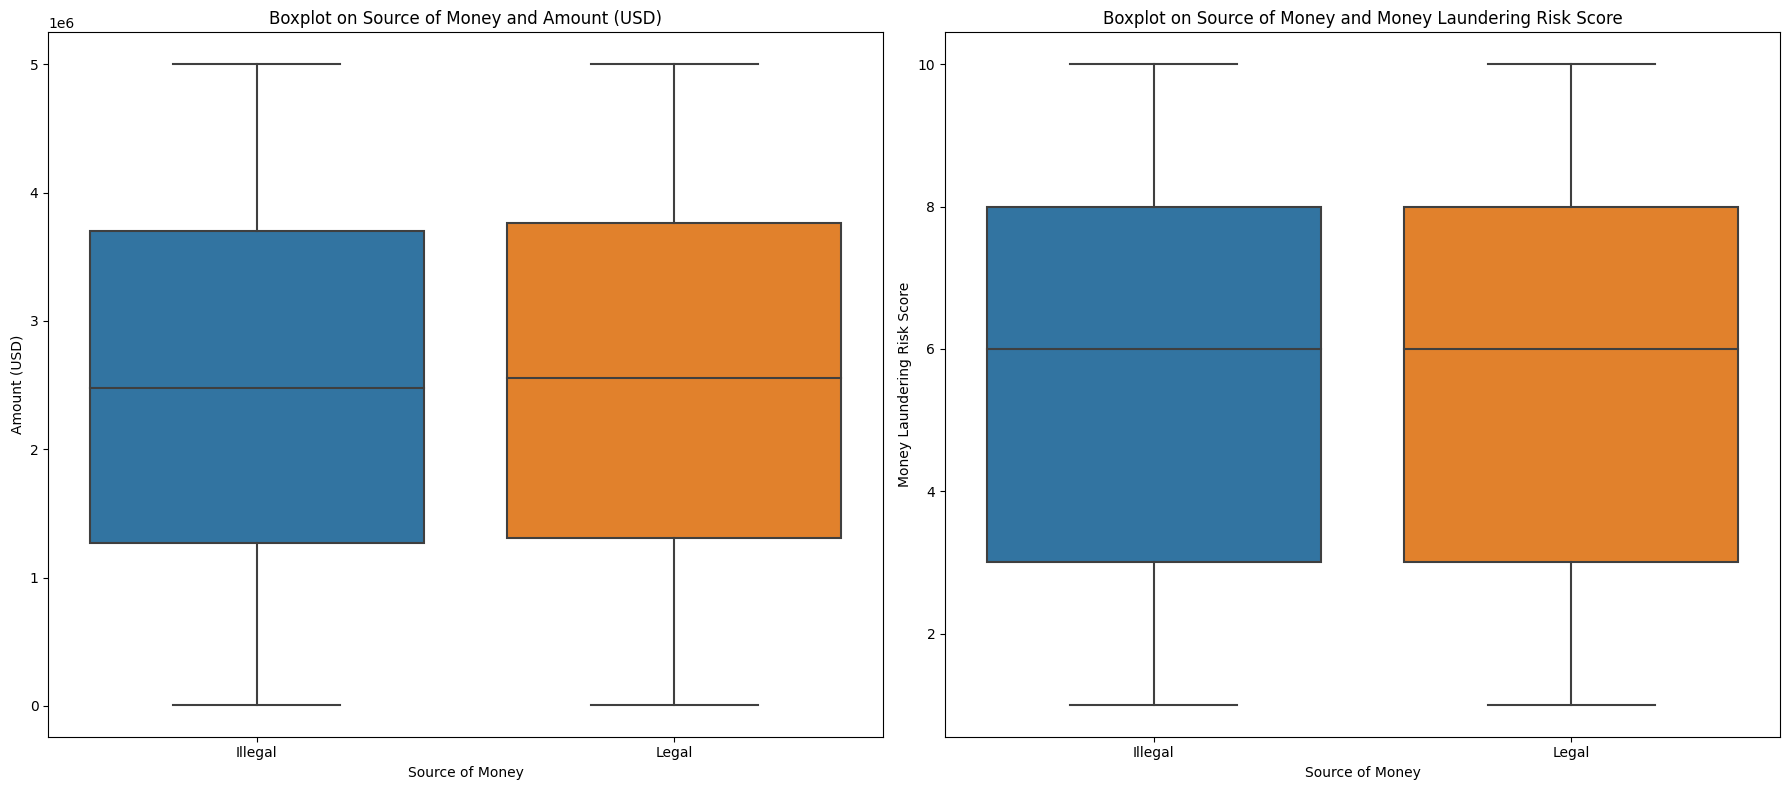

In [55]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))
axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data = black_money, x = 'Source of Money', y = feature, ax = axes[i])
    axes[i].set_xlabel('Source of Money')
    axes[i].set_ylabel(feature)
    axes[i].set_title(f'Boxplot on Source of Money and {feature}')
    
plt.tight_layout()
plt.show()

For those illegal money transactions, the amount of money transaction is slightly lower than that of legal money transactions and risk score tends to be the same for both.

## Data Preprocessing / Feature Engineering

Considering the dataset with a lot of categorical features, it would be better to encode categorical features and perform feature engineering for better performance of the model

In [56]:
black_money.head()

,Country,Amount (USD),Transaction Type,Date of Transaction,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
0,Brazil,3.267530e+06,Offshore Transfer,2013-01-01 00:00:00,Construction,USA,True,Illegal,6,1,Bank_40,Singapore
1,China,4.965767e+06,Stocks Transfer,2013-01-01 01:00:00,Luxury Goods,South Africa,False,Illegal,9,0,Bank_461,Bahamas
2,UK,9.416750e+04,Stocks Transfer,2013-01-01 02:00:00,Construction,Switzerland,True,Illegal,1,3,Bank_387,Switzerland
3,UAE,3.864201e+05,Cash Withdrawal,2013-01-01 03:00:00,Oil & Gas,Russia,False,Illegal,7,2,Bank_353,Panama
4,South Africa,6.433784e+05,Cryptocurrency,2013-01-01 04:00:00,Real Estate,USA,True,Illegal,1,9,Bank_57,Luxembourg


In [57]:
black_money_enc = black_money.copy()

In [58]:
## Convert the financial instituition information into numeric values
black_money_enc['Financial Institution'] = black_money_enc['Financial Institution'].str.replace('Bank_', '', regex = False).astype('int')

In [59]:
# Extracting features from the date
black_money_enc['Year'] = black_money_enc['Date of Transaction'].dt.year
black_money_enc['Month'] = black_money_enc['Date of Transaction'].dt.month
black_money_enc['Day'] = black_money_enc['Date of Transaction'].dt.day
black_money_enc['DayOfWeek'] = black_money_enc['Date of Transaction'].dt.dayofweek
black_money_enc['Hour'] = black_money_enc['Date of Transaction'].dt.hour
black_money_enc.drop(['Date of Transaction'], axis = 1, inplace = True)

In [60]:
# Binning the transaction amount
black_money_enc['Amount Category'] = pd.cut(black_money_enc['Amount (USD)'], bins=[0, 10000, 50000, 100000, 500000, float('inf')],
                               labels=['Low', 'Medium', 'High', 'Very High', 'Extreme'])

# Creating interaction terms
black_money_enc['Amount_Risk_Interaction'] = black_money_enc['Amount (USD)'] * black_money_enc['Money Laundering Risk Score']
black_money_enc.drop(columns = ['Amount (USD)', 'Money Laundering Risk Score'], axis = 1, inplace = True)



In [61]:
black_money_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Country                   10000 non-null  object  
 1   Transaction Type          10000 non-null  object  
 2   Industry                  10000 non-null  object  
 3   Destination Country       10000 non-null  object  
 4   Reported by Authority     10000 non-null  bool    
 5   Source of Money           10000 non-null  object  
 6   Shell Companies Involved  10000 non-null  object  
 7   Financial Institution     10000 non-null  int64   
 8   Tax Haven Country         10000 non-null  object  
 9   Year                      10000 non-null  int32   
 10  Month                     10000 non-null  int32   
 11  Day                       10000 non-null  int32   
 12  DayOfWeek                 10000 non-null  int32   
 13  Hour                      10000 non-null  int32

In [62]:
encoding_features = black_money_enc.select_dtypes(include = ['object', 'bool', 'category'])

In [63]:
encoding_features

,Country,Transaction Type,Industry,Destination Country,Reported by Authority,Source of Money,Shell Companies Involved,Tax Haven Country,Amount Category
0,Brazil,Offshore Transfer,Construction,USA,True,Illegal,1,Singapore,Extreme
1,China,Stocks Transfer,Luxury Goods,South Africa,False,Illegal,0,Bahamas,Extreme
2,UK,Stocks Transfer,Construction,Switzerland,True,Illegal,3,Switzerland,High
3,UAE,Cash Withdrawal,Oil & Gas,Russia,False,Illegal,2,Panama,Very High
4,South Africa,Cryptocurrency,Real Estate,USA,True,Illegal,9,Luxembourg,Extreme
...,...,...,...,...,...,...,...,...,...
9995,Singapore,Offshore Transfer,Real Estate,Brazil,False,Illegal,4,Luxembourg,Extreme
9996,UAE,Property Purchase,Luxury Goods,Russia,False,Legal,2,Luxembourg,Extreme
9997,UK,Stocks Transfer,Oil & Gas,Russia,False,Illegal,0,Cayman Islands,Very High
9998,Brazil,Offshore Transfer,Real Estate,Russia,True,Illegal,5,Singapore,Extreme


In [64]:
le = LabelEncoder()

for col in encoding_features.columns:
    black_money_enc[col] = le.fit_transform(black_money_enc[col])

In [65]:
black_money_enc.head()

,Country,Transaction Type,Industry,Destination Country,Reported by Authority,Source of Money,Shell Companies Involved,Financial Institution,Tax Haven Country,Year,Month,Day,DayOfWeek,Hour,Amount Category,Amount_Risk_Interaction
0,0,2,2,9,1,0,1,40,4,2013,1,1,1,0,0,1.960518e+07
1,1,4,4,5,0,0,0,461,0,2013,1,1,1,1,0,4.469190e+07
2,8,4,2,6,1,0,3,387,5,2013,1,1,1,2,1,9.416750e+04
3,7,0,5,3,0,0,2,353,3,2013,1,1,1,3,3,2.704941e+06
4,5,1,6,9,1,0,9,57,2,2013,1,1,1,4,0,6.433784e+05


I have created a new interaction term for model to better grasp the nonlinear relationship

Let's check again if there are no missing values after EDA

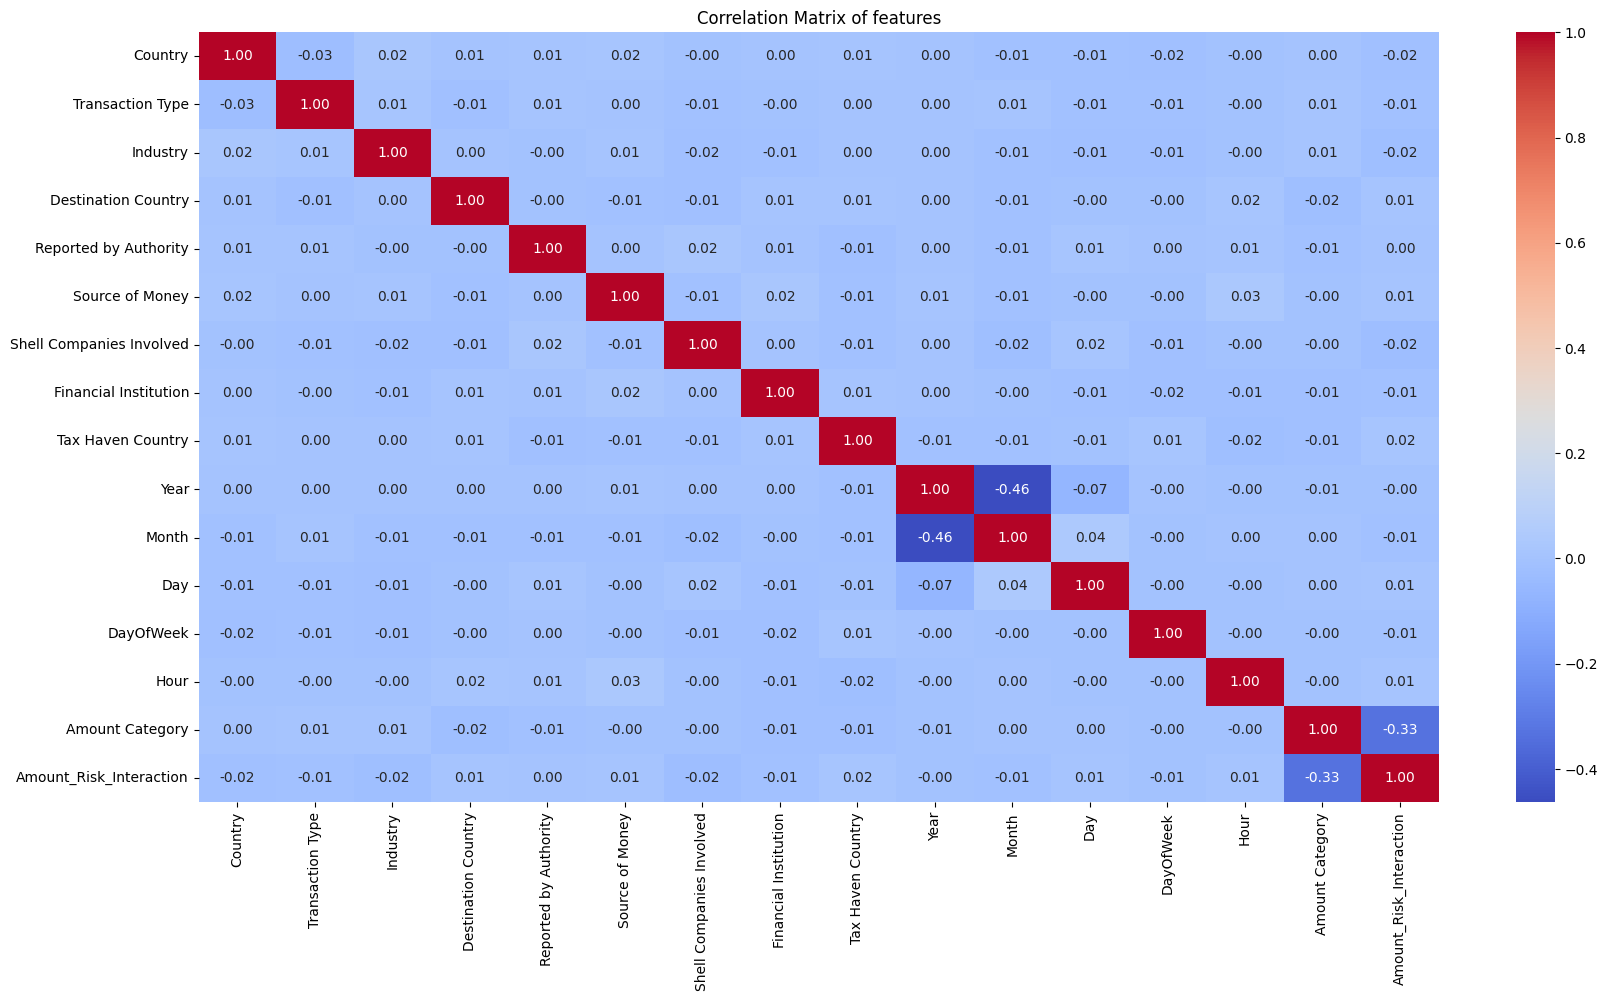

In [66]:
correlation_matrix = black_money_enc.corr()
plt.figure(figsize = (20, 10))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Matrix of features')
plt.show()

Considering the large number of variables, it would be better to limit only some variables to be visible

Text(0.5, 1.0, 'Correlation on Heatmap')

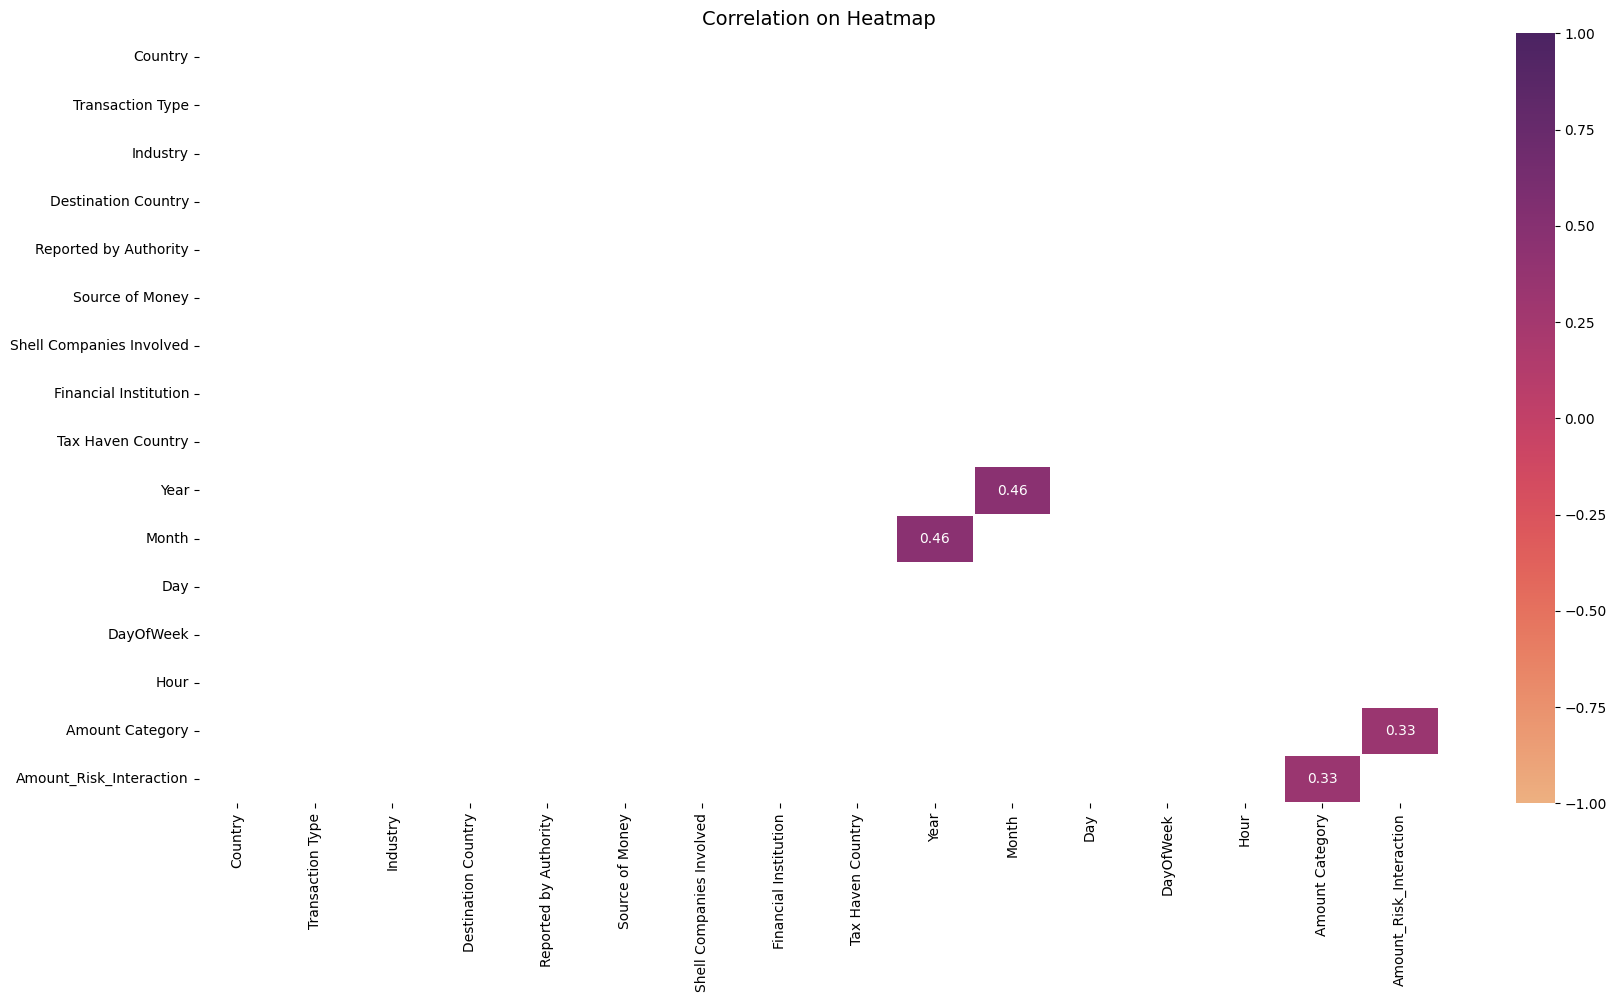

In [67]:
## Establish heatmap size
plt.figure(figsize = (20, 10))

## create correlation matrix with abs values
corr_matrix = black_money_enc.corr().abs()

## Selected 0.5 to only see highly correlated variables
threshold = 0.25

## Filter the Correlation matrix based on the threshold
filtered_corr_df = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.000)]

## Create Heatmap
heatmap = sns.heatmap(filtered_corr_df, vmin = -1, vmax = 1, annot = True, xticklabels = True, yticklabels = True, cmap = sns.color_palette('flare', as_cmap = True), linewidths = 0.1)
heatmap.set_title('Correlation on Heatmap', fontdict = {'fontsize' : 14})

In [68]:
black_money_enc.isna().any(axis = 1).sum()

0

Now we will look at correlation matrix

Now before I prepare for data splitting, checking target label proportion is important

In [69]:
black_money_enc['Source of Money'].value_counts(normalize = True)

Source of Money
0    0.7017
1    0.2983
Name: proportion, dtype: float64

which seems that the data is imbalanced, so it is better to upsample the data considering volume of our data entries.

In [70]:
copied_data = black_money_enc.copy()

## Split X and y
X = copied_data.drop('Source of Money', axis = 1)
y = copied_data['Source of Money']

## Split the dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 11, stratify = y)

## Initiate Upsampler and upsample the data
smote = SMOTE(random_state = 11)
X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train, y_train)

## Normalize features
scaler = MinMaxScaler()
X_train_upsampled = scaler.fit_transform(X_train_upsampled)
X_test = scaler.transform(X_test)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [71]:
X_train_upsampled.shape, y_train_upsampled.shape

((10526, 15), (10526,))

## Model Construction

In [72]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('classification_report : \n', classification_report(y_test, y_pred))
    print(f'Accuracy : {accuracy_score(y_test, y_pred)}')
    print(f'Recall : {recall_score(y_test, y_pred)}')
    print(f'Precision : {precision_score(y_test, y_pred)}')
    print(f'F1 score : {f1_score(y_test, y_pred)}')
    print(f'AUC : {roc_auc_score(y_test, y_pred)}')
    print('')
    
    # ROC Curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Logistic Regression

Logistic Regression : 

classification_report : 
               precision    recall  f1-score   support

           0       0.64      0.01      0.01      1403
           1       0.30      0.99      0.46       597

    accuracy                           0.30      2000
   macro avg       0.47      0.50      0.24      2000
weighted avg       0.54      0.30      0.15      2000

Accuracy : 0.3005
Recall : 0.9916247906197655
Precision : 0.2980866062437059
F1 score : 0.4583817266744096
AUC : 0.4990198079969818



/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



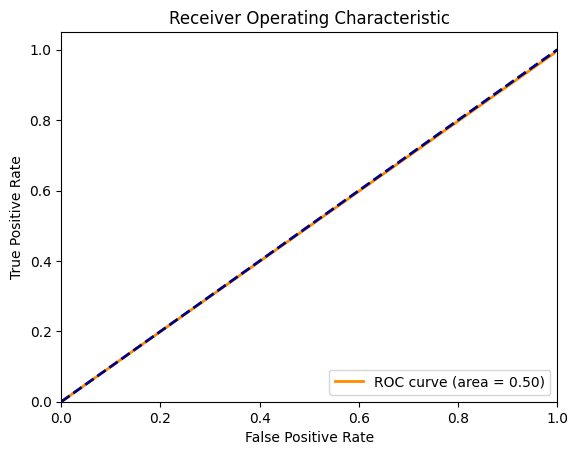

In [73]:
print('Logistic Regression : \n')
log_clf = LogisticRegression(random_state = 42)
evaluate_model(log_clf, X_train_upsampled, y_train_upsampled, X_test, y_test)

## Support Vector Machine

SVM Model : 



/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Unde

classification_report : 
               precision    recall  f1-score   support

           0       0.70      1.00      0.82      1403
           1       0.00      0.00      0.00       597

    accuracy                           0.70      2000
   macro avg       0.35      0.50      0.41      2000
weighted avg       0.49      0.70      0.58      2000

Accuracy : 0.7015
Recall : 0.0
Precision : 0.0
F1 score : 0.0
AUC : 0.5



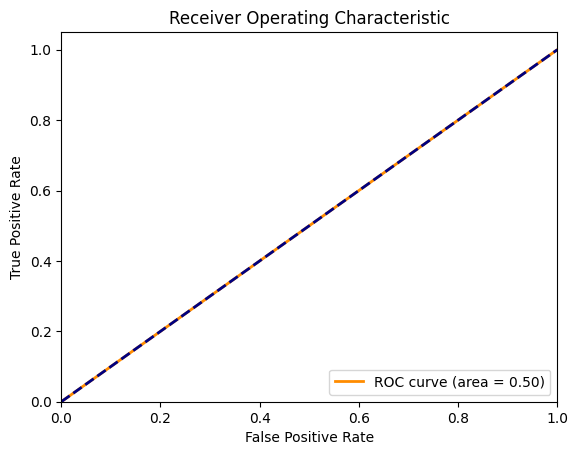

In [74]:
# Support Vector Machine (SVM) Model
print("SVM Model : \n")
svm_model = SVC(probability=True, random_state=42)  # Enable probability estimates for ROC curve
evaluate_model(svm_model, X_train_upsampled, y_train_upsampled, X_test, y_test)

## Decision Tree

Decision Tree : 

classification_report : 
               precision    recall  f1-score   support

           0       0.69      0.28      0.40      1403
           1       0.29      0.71      0.41       597

    accuracy                           0.41      2000
   macro avg       0.49      0.49      0.41      2000
weighted avg       0.57      0.41      0.40      2000

Accuracy : 0.4055
Recall : 0.7051926298157454
Precision : 0.29358437935843795
F1 score : 0.41457410142786805
AUC : 0.49158419801549913



/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



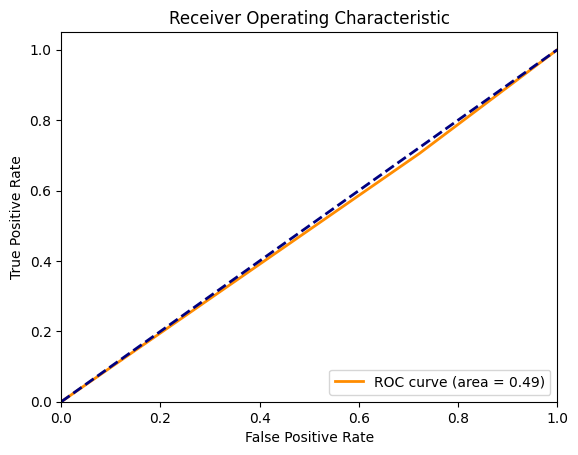

In [75]:
print('Decision Tree : \n')
dt_clf = DecisionTreeClassifier(random_state = 21)
evaluate_model(dt_clf, X_train_upsampled, y_train_upsampled, X_test, y_test)

## Random Forest 

Random Forest : 



/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



classification_report : 
               precision    recall  f1-score   support

           0       0.70      0.99      0.82      1403
           1       0.33      0.01      0.02       597

    accuracy                           0.70      2000
   macro avg       0.52      0.50      0.42      2000
weighted avg       0.59      0.70      0.58      2000

Accuracy : 0.699
Recall : 0.008375209380234505
Precision : 0.3333333333333333
F1 score : 0.01633986928104575
AUC : 0.5006238128155627



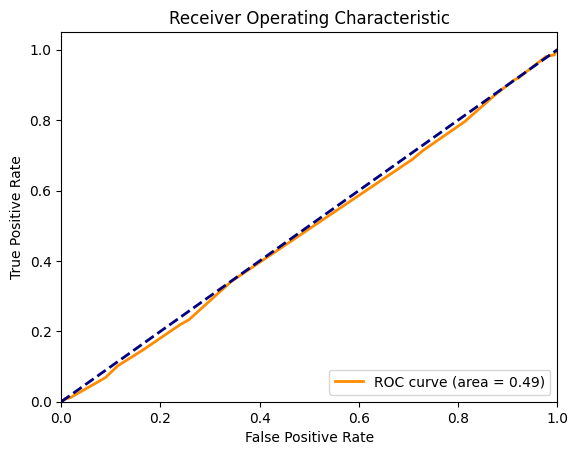

In [76]:
print('Random Forest : \n')
rf_clf = RandomForestClassifier(random_state = 11)
evaluate_model(rf_clf, X_train_upsampled, y_train_upsampled, X_test, y_test)

## XGBoost

XGBoost : 

classification_report : 
               precision    recall  f1-score   support

           0       0.70      0.72      0.71      1403
           1       0.30      0.29      0.30       597

    accuracy                           0.59      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.58      0.59      0.59      2000

Accuracy : 0.589
Recall : 0.2897822445561139
Precision : 0.30297723292469353
F1 score : 0.2962328767123288
AUC : 0.5030522056707868



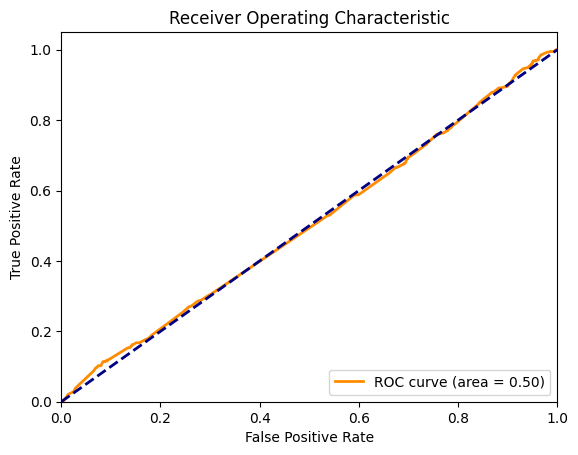

In [77]:
print('XGBoost : \n')
xgb_clf = XGBClassifier(random_state = 11)
evaluate_model(xgb_clf, X_train_upsampled, y_train_upsampled, X_test, y_test)